In [15]:
import os
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F
from cnn import Cnn
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image as pil
%matplotlib inline
color_b = sns.color_palette("Blues_r")
# Seaborn's palette for drawing charts
img_saving = False
# (DEBUG) whether to save the drawn picture..

In [16]:
if torch.cuda.is_available():
    print('Now using:', torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 
print('Device name:', device)

Now using: GeForce GTX 1050 Ti
Device name: cuda:0


In [17]:
class Loader():
    def __init__(self, data: np.ndarray, bsz: int, label=None):
        self.data = data
        self.bsz = bsz
        self.p = 0
        self.label = label
    
    def __iter__(self):
        self.p = 0
        return self
    
    def __next__(self):
        if self.p >= self.data.shape[0]:
            raise StopIteration
        else:
            pp = min(self.data.shape[0], self.p + self.bsz)
            r1 = self.data[self.p: pp]
            if self.label is None:
                self.p = pp
                return r1
            else:
                r2 = self.label[self.p: pp]
                self.p = pp
                return (r1, r2)
    def __len__(self):
        return self.data.shape[0]

(28708, 48, 48)
(28708, 1)


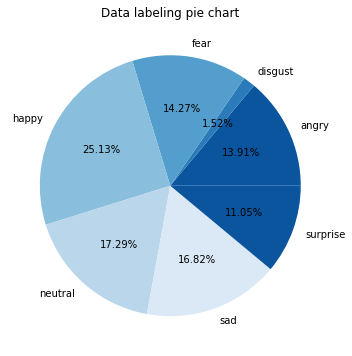

In [18]:
catyDict = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

train_x = np.zeros((0, 48, 48))
train_y = np.zeros((0, 1))
train_path = 'train'
caty_ns = []
for c in catyDict:
    asy = os.listdir(os.path.join(train_path, c))
    maty = np.zeros((len(asy), 48, 48))
    for (ind, i) in enumerate(asy):
        x = np.asarray(pil.open(os.path.join(train_path, c, i))).copy()
        if x.std() > 1:
            x= (x - x.mean()) / x.std()
        maty[ind, :, :] = x
    train_x = np.vstack((train_x, maty))
    train_y = np.vstack((train_y, np.full((maty.shape[0], 1), catyDict[c])))
    caty_ns.append(maty.shape[0])
print(train_x.shape)
print(train_y.shape)
plt.figure(figsize=(6, 6))
plt.pie(caty_ns, colors=color_b[0 : 7],
        labels=[c for c in catyDict.keys()],
        autopct='%.2f%%')
plt.title('Data labeling pie chart')
if img_saving:
    plt.savefig('1_1.png', bbox_inches='tight')
#plt.show()
#print(apic.size)

[[[-1.09612274 -1.44844517 -1.78119414 ...  0.52847516  0.88079759
   -0.39147787]
  [-0.95910846 -1.40929824 -1.64417986 ...  0.6263425   0.88079759
   -0.33275746]
  [-0.88081458 -1.48759211 -1.60503292 ...  0.70463638  0.84165066
   -0.33275746]
  ...
  [-0.0587289  -0.11744931 -0.11744931 ...  0.84165066 -0.03915543
   -0.41105134]
  [ 0.01956497  0.09785885  0.13700578 ...  0.88079759  0.27402007
   -0.39147787]
  [-0.03915543 -0.03915543  0.11743232 ...  0.72420984  0.58719556
   -0.45019827]]]
[25242 19859 20081 ... 23415 14513 20076]


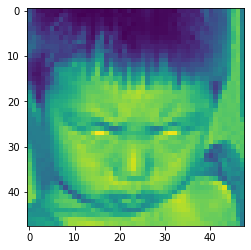

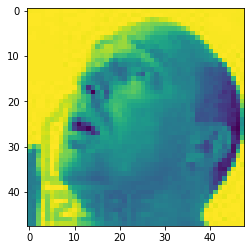

In [19]:
train_x = np.expand_dims(train_x, axis=1)
print(train_x[0])
plt.imshow(train_x[0][0])
per = np.random.permutation(train_x.shape[0])		#打乱后的行号
rtrain_x = torch.from_numpy(train_x[per])
rtrain_y = torch.from_numpy(train_y[per]).squeeze()
print(per)
plt.figure()
plt.imshow(rtrain_x[0][0])

In [20]:
cnn = Cnn()
cnn.to(device)
print(cnn)
dummy_input = torch.randn(1, 1, 48, 48, device=device)
torch.onnx.export(cnn, dummy_input, "convnet.onnx", verbose=True, input_names=['input'], output_names=['output'])

Cnn(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn6): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [21]:
learn_rate = 3e-4
los = nn.CrossEntropyLoss()
loader = Loader(rtrain_x, 64, label=rtrain_y)
optim = torch.optim.Adam(cnn.parameters(), lr=learn_rate)
for ep in range(24):
    print('epoches: %d' % ep)
    for i, (x, y) in enumerate(loader):
        optim.zero_grad()
        x = x.to(device, dtype=torch.float)
        #print(x.shape)
        y = y.to(device, dtype=torch.long)
        #print(y)
        outt = cnn(x)
        loss = los(outt, y)
        #print(loss)
        loss.backward()
        optim.step()
        if (i + 1) % (int(len(loader) / loader.bsz / 100)) == 0:
            print('\r', '%d %%' % ((i + 1) / (len(loader) / loader.bsz ) * 100), end="", flush=True)
    
    print('')
    #acc = torch.Tensor([0.]).squeeze().to(device)
    #for i, (x, y) in enumerate(loader):
     #   o = cnn(x.to(device, dtype=torch.float))
      #  add = torch.sum(torch.argmax(o, 1) == y.to(device, dtype=torch.long)).to(torch.float64)
       # acc += add
    #print('accuary', acc.cpu().numpy() / len(loader) * 100, '%')
acc = torch.Tensor([0.]).squeeze().to(device)
torch.cuda.empty_cache()
# Clear cuda cache
for i, (x, y) in enumerate(loader):
    o = cnn(x.to(device, dtype=torch.float))
    add = torch.sum(torch.argmax(o, 1) == y.to(device, dtype=torch.long)).to(torch.float64)
    acc += add

print('accuary', acc.cpu().numpy() / len(loader) * 100, '%')
torch.save(cnn.state_dict(), 'convnet.pkl')
#dummy_input = torch.randn(1, 1, 48, 48, device=device)
#torch.onnx.export(cnn, dummy_input, "convnet.onnx", verbose=True, input_names=['input'], output_names=['output'])
caty_dict_ = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}
cnn = Cnn()
cnn.load_state_dict(torch.load('convnet.pkl'))
print(cnn)
test_dic = 'test'
df = pd.read_csv('submission.csv')
print(df.head())

for i in range(df.shape[0]):

    s = df['file_name'][i]
    x = np.asarray(pil.open(os.path.join(test_dic, s)))
    x = (x - x.mean()) / x.std()
    x = np.expand_dims(np.expand_dims(x, axis=0), axis=0)
    x = torch.from_numpy(x).to('cpu', dtype=torch.float)
    df['class'][i] = caty_dict_[torch.argmax(cnn(x), 1).numpy()[0]]
    if i % 1000 == 0:
        print(i, s)
print(df['class'].value_counts())
df.to_csv('submission.csv', index=False)

epoches: 0
 99 %
epoches: 1
 99 %
epoches: 2
 99 %
epoches: 3
 99 %
epoches: 4
 99 %73 %
epoches: 5
 99 %
epoches: 6
 99 %
epoches: 7
 99 %
epoches: 8
 99 %
epoches: 9
 99 % %10 %75 %
epoches: 10
 99 %
epoches: 11
 99 %
epoches: 12
 99 %
epoches: 13
 99 %
epoches: 14
 99 %
epoches: 15
 99 %
epoches: 16
 99 %
epoches: 17
 99 %
epoches: 18
 99 %
epoches: 19
 99 %
epoches: 20
 99 %
epoches: 21
 99 %
epoches: 22
 99 %
epoches: 23
 99 %
accuary 78.52514978403232 %
Cnn(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

<ipython-input-21-55bb099ba278>:60: RuntimeWarning: invalid value encountered in true_divide
  x = (x - x.mean()) / x.std()
